In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
#from finrl.trade.backtest import backtest_stats, baseline_stats, backtest_plot
from finrl.trade.backtest import backtest_stats, get_baseline, backtest_plot

import sys
sys.path.append("../FinRL-Library")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/jongohkim/opt/anaconda3/envs/rl_Study/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [5]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [6]:
# from config.py end_date is a string
config.END_DATE

'2021-01-01'

In [7]:
# Download and save the data in a pandas DataFrame:
data_df = YahooDownloader(start_date = '2009-01-01',
                          end_date = '2021-01-01',
                          ticker_list = ['AAPL']).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3022, 8)


In [8]:
data_df.shape

(3022, 8)

In [9]:
data_df.head()

,date,open,high,low,close,volume,tic,day
0,2008-12-31,3.070357,3.133571,3.047857,2.625620,607541200,AAPL,2
1,2009-01-02,3.067143,3.251429,3.041429,2.791740,746015200,AAPL,4
2,2009-01-05,3.327500,3.435000,3.311071,2.909563,1181608400,AAPL,0
3,2009-01-06,3.426786,3.470357,3.299643,2.861573,1289310400,AAPL,1
4,2009-01-07,3.278929,3.303571,3.223571,2.799739,753048800,AAPL,2


In [10]:
tech_indicator_list=config.TECHNICAL_INDICATORS_LIST
print(tech_indicator_list)

['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']


In [11]:
## user can add more technical indicators
## check https://github.com/jealous/stockstats for different names
tech_indicator_list=tech_indicator_list+['kdjk','open_2_sma','boll','close_10.0_le_5_c','wr_10','dma','trix']
print(tech_indicator_list)

['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma', 'kdjk', 'open_2_sma', 'boll', 'close_10.0_le_5_c', 'wr_10', 'dma', 'trix']


In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=False,
                    user_defined_feature = False)

data_df = fe.preprocess_data(data_df)

Successfully added technical indicators


In [13]:
data_df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,dx_30,close_30_sma,close_60_sma,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix
0,2008-12-31,3.070357,3.133571,3.047857,2.625620,607541200,AAPL,2,0.000000,2.943609,...,100.000000,2.625620,2.625620,-130.870722,3.070357,2.625620,1.0,592.612167,0.0,1.005509
1,2009-01-02,3.067143,3.251429,3.041429,2.791740,746015200,AAPL,4,0.003727,2.943609,...,100.000000,2.708680,2.708680,-126.880332,3.068750,2.708680,2.0,218.899551,0.0,1.005509
2,2009-01-05,3.327500,3.435000,3.311071,2.909563,1181608400,AAPL,0,0.008403,3.060949,...,100.000000,2.775641,2.775641,-95.755266,3.197322,2.775641,3.0,133.505133,0.0,1.000507
3,2009-01-06,3.426786,3.470357,3.299643,2.861573,1289310400,AAPL,1,0.008591,3.045421,...,100.000000,2.797124,2.797124,-77.814023,3.377143,2.797124,4.0,141.931537,0.0,0.836218
4,2009-01-07,3.278929,3.303571,3.223571,2.799739,753048800,AAPL,2,0.006051,3.012691,...,58.462756,2.797647,2.797647,-70.658498,3.352857,2.797647,5.0,156.347447,0.0,0.653105


In [14]:
#train = data_split(data_df, start = config.START_DATE, end = config.START_TRADE_DATE)
#trade = data_split(data_df, start = config.START_TRADE_DATE, end = config.END_DATE)
train = data_split(data_df, start = '2009-01-01', end = '2019-01-01')
trade = data_split(data_df, start = '2019-01-01', end = '2021-01-01')

In [15]:
## data normalization, this part is optional, have little impact
#feaures_list = list(train.columns)
#feaures_list.remove('date')
#feaures_list.remove('tic')
#feaures_list.remove('close')
#print(feaures_list)
#from sklearn import preprocessing
#data_normaliser = preprocessing.StandardScaler()
#train[feaures_list] = data_normaliser.fit_transform(train[feaures_list])
#trade[feaures_list] = data_normaliser.transform(trade[feaures_list])

In [16]:
## we store the stockstats technical indicator column names in config.py
## check https://github.com/jealous/stockstats for different names
tech_indicator_list

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma',
 'kdjk',
 'open_2_sma',
 'boll',
 'close_10.0_le_5_c',
 'wr_10',
 'dma',
 'trix']

In [17]:
# the stock dimension is 1, because we only use the price data of AAPL.
len(train.tic.unique())

1

In [18]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [19]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [20]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [21]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [22]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

Logging to tensorboard_log/a2c/a2c_10
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.46    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 0.00149  |
|    std                | 1.04     |
|    value_loss         | 1.44e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 153      |
|    iterations         | 200      |
|    time_elapsed       | 6        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.47    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 199      |


------------------------------------
| time/                 |          |
|    fps                | 342      |
|    iterations         | 1500     |
|    time_elapsed       | 21       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -1.48    |
|    explained_variance | 0.0162   |
|    learning_rate      | 0.0002   |
|    n_updates          | 1499     |
|    policy_loss        | -1.74    |
|    std                | 1.07     |
|    value_loss         | 3.11     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 5.01e+05 |
|    total_cost         | 3.39e+03 |
|    total_reward       | 4.01e+05 |
|    total_reward_pct   | 401      |
|    total_trades       | 2496     |
| time/                 |          |
|    fps                | 343      |
|    iterations         | 1600     |
|    time_elapsed       | 23       |
|    total_timesteps    | 8000     |
|

------------------------------------
| time/                 |          |
|    fps                | 358      |
|    iterations         | 2900     |
|    time_elapsed       | 40       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -1.47    |
|    explained_variance | 0.18     |
|    learning_rate      | 0.0002   |
|    n_updates          | 2899     |
|    policy_loss        | -0.105   |
|    std                | 1.05     |
|    value_loss         | 0.0757   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 360      |
|    iterations         | 3000     |
|    time_elapsed       | 41       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -1.47    |
|    explained_variance | 0.0154   |
|    learning_rate      | 0.0002   |
|    n_updates          | 2999     |
|    policy_loss        | 0.947    |
|

------------------------------------
| time/                 |          |
|    fps                | 353      |
|    iterations         | 4300     |
|    time_elapsed       | 60       |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -1.48    |
|    explained_variance | 0.542    |
|    learning_rate      | 0.0002   |
|    n_updates          | 4299     |
|    policy_loss        | 1.03     |
|    std                | 1.06     |
|    value_loss         | 0.535    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 354      |
|    iterations         | 4400     |
|    time_elapsed       | 62       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -1.48    |
|    explained_variance | -0.269   |
|    learning_rate      | 0.0002   |
|    n_updates          | 4399     |
|    policy_loss        | -1.24    |
|

------------------------------------
| time/                 |          |
|    fps                | 363      |
|    iterations         | 5700     |
|    time_elapsed       | 78       |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -1.48    |
|    explained_variance | -0.0447  |
|    learning_rate      | 0.0002   |
|    n_updates          | 5699     |
|    policy_loss        | 1.13     |
|    std                | 1.06     |
|    value_loss         | 0.907    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 364      |
|    iterations         | 5800     |
|    time_elapsed       | 79       |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -1.47    |
|    explained_variance | -0.0505  |
|    learning_rate      | 0.0002   |
|    n_updates          | 5799     |
|    policy_loss        | 0.00423  |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 6.93e+05  |
|    total_cost         | 3.58e+03  |
|    total_reward       | 5.93e+05  |
|    total_reward_pct   | 593       |
|    total_trades       | 2494      |
| time/                 |           |
|    fps                | 370       |
|    iterations         | 7100      |
|    time_elapsed       | 95        |
|    total_timesteps    | 35500     |
| train/                |           |
|    entropy_loss       | -1.49     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 7099      |
|    policy_loss        | -0.581    |
|    std                | 1.07      |
|    value_loss         | 0.339     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 370      |
|    iterations         | 7200     |
|    time_elapsed       | 97       |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 376      |
|    iterations         | 8500     |
|    time_elapsed       | 112      |
|    total_timesteps    | 42500    |
| train/                |          |
|    entropy_loss       | -1.49    |
|    explained_variance | -0.0242  |
|    learning_rate      | 0.0002   |
|    n_updates          | 8499     |
|    policy_loss        | 2.49     |
|    std                | 1.08     |
|    value_loss         | 3.17     |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 7.04e+05  |
|    total_cost         | 3.58e+03  |
|    total_reward       | 6.04e+05  |
|    total_reward_pct   | 604       |
|    total_trades       | 2498      |
| time/                 |           |
|    fps                | 376       |
|    iterations         | 8600      |
|    time_elapsed       | 114       |
|    total_timesteps    | 4

------------------------------------
| time/                 |          |
|    fps                | 380      |
|    iterations         | 9900     |
|    time_elapsed       | 130      |
|    total_timesteps    | 49500    |
| train/                |          |
|    entropy_loss       | -1.49    |
|    explained_variance | 0.0154   |
|    learning_rate      | 0.0002   |
|    n_updates          | 9899     |
|    policy_loss        | -1.51    |
|    std                | 1.07     |
|    value_loss         | 0.886    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 380      |
|    iterations         | 10000    |
|    time_elapsed       | 131      |
|    total_timesteps    | 50000    |
| train/                |          |
|    entropy_loss       | -1.48    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 9999     |
|    policy_loss        | -0.0315  |
|

In [22]:
trade.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,dx_30,close_30_sma,close_60_sma,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix
0,2019-01-02,38.722500,39.712502,38.557499,38.505024,148158800,AAPL,2,-2.016889,44.505522,...,42.250808,41.225720,46.488189,26.255061,39.177500,39.975055,0.0,64.517199,-6.875741,-0.761653
1,2019-01-03,35.994999,36.430000,35.500000,34.669640,365248800,AAPL,3,-2.199742,43.911981,...,55.246973,40.808453,46.157722,11.997918,37.358749,39.455339,0.0,113.050853,-7.085639,-0.763467
2,2019-01-04,36.132500,37.137501,35.950001,36.149662,234428400,AAPL,4,-2.199870,43.454764,...,47.060632,40.502857,45.854029,12.988335,36.063749,39.108740,0.0,87.077832,-7.044321,-0.766086
3,2019-01-07,37.174999,37.207500,36.474998,36.069202,219111200,AAPL,0,-2.181318,43.003009,...,46.245025,40.266752,45.536440,13.030644,36.653749,38.782134,0.0,86.884737,-6.900339,-0.767321
4,2019-01-08,37.389999,37.955002,37.130001,36.756794,164101200,AAPL,1,-2.087075,42.733426,...,37.537680,40.055192,45.272874,18.339891,37.282499,38.565861,0.0,71.041614,-6.589742,-0.759067


In [24]:
## make a prediction and get the account value change
trade = data_split(data_df, start = '2019-01-01', end = '2021-01-01')

e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
#env_trade, obs_trade = e_trade_gym.get_sb_env()

df_account_value, df_actions = DRLAgent.DRL_prediction(trained_a2c,e_trade_gym)

hit end!


In [26]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.829679
Cumulative returns     2.355762
Annual volatility      0.363259
Sharpe ratio           1.849808
Calmar ratio           2.652813
Stability              0.936066
Max drawdown          -0.312755
Omega ratio            1.419298
Sortino ratio          2.797184
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.095116
Daily value at risk   -0.043100
dtype: float64


In [27]:
#backtest_stats, get_baseline, backtest_plot

==============Compare to AAPL itself buy-and-hold===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,82.968%
Cumulative returns,235.576%
Annual volatility,36.326%
Sharpe ratio,1.85
Calmar ratio,2.65
Stability,0.94
Max drawdown,-31.275%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.28,2020-02-12,2020-03-23,2020-06-05,83
1,20.35,2020-09-01,2020-09-18,2020-12-28,85
2,17.70,2019-05-03,2019-06-03,2019-07-31,64
3,9.25,2019-07-31,2019-08-05,2019-08-21,16
4,5.85,2020-07-20,2020-07-24,2020-07-31,10


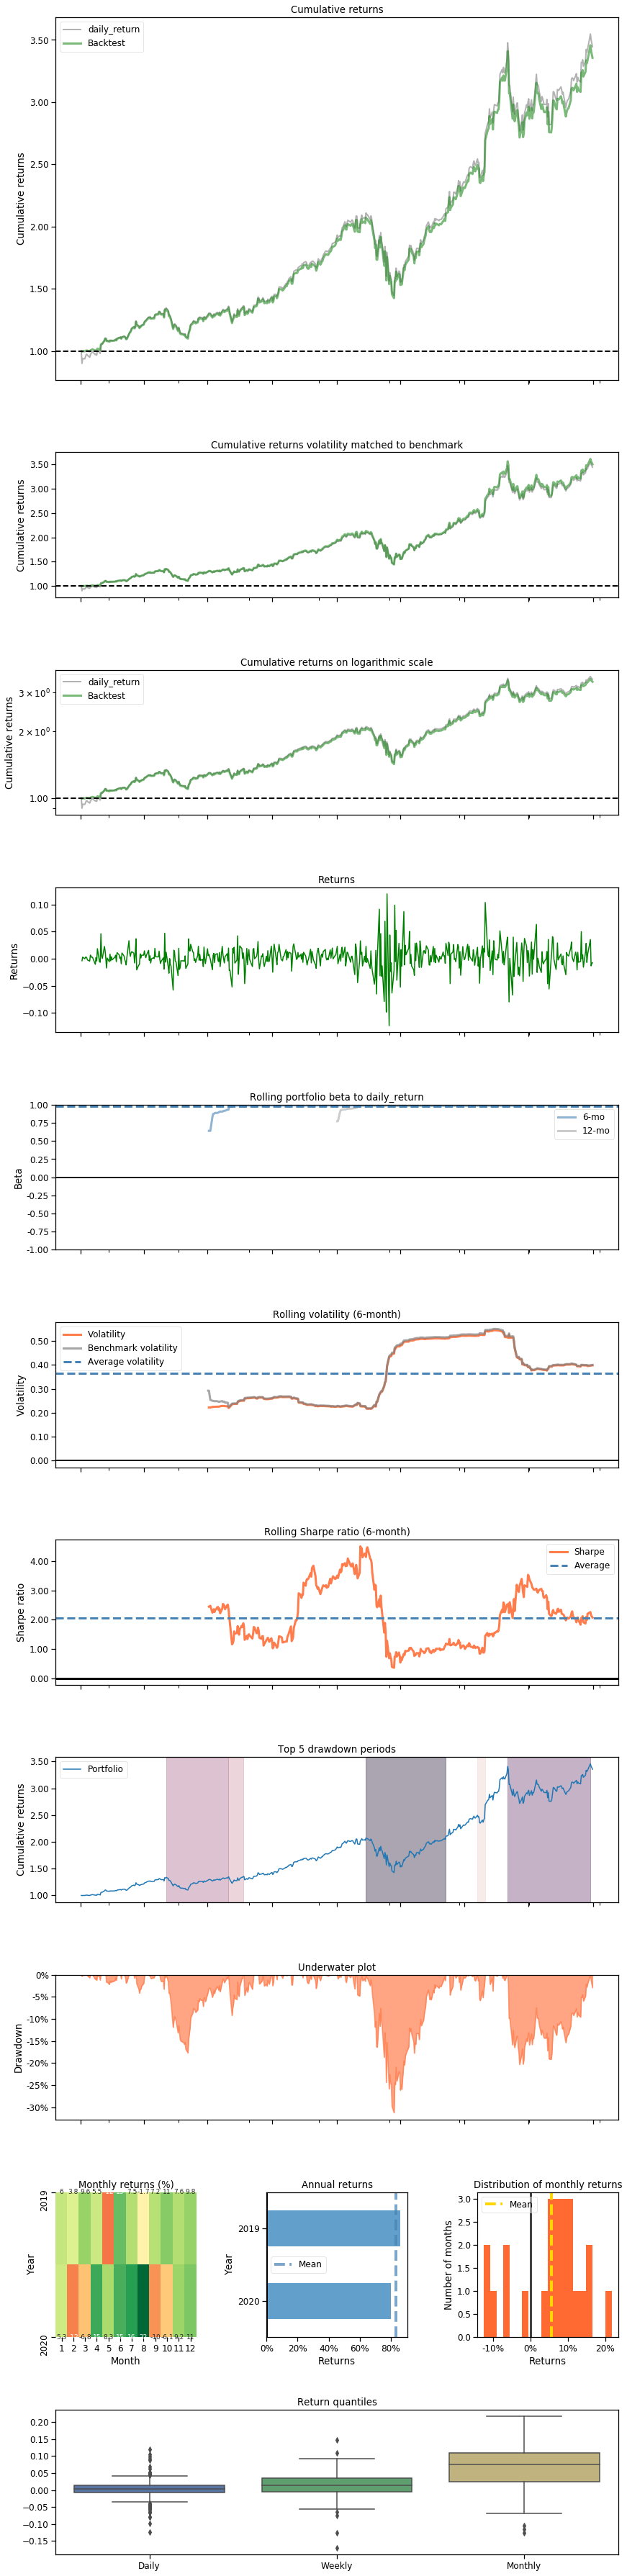

In [28]:
print("==============Compare to AAPL itself buy-and-hold===========")
%matplotlib inline
backtest_plot(account_value=df_account_value, 
             baseline_ticker = 'AAPL',
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01')

In [31]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=get_baseline('AAPL','2019-01-01','2021-01-01')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


In [32]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=get_baseline('^GSPC','2019-01-01','2021-01-01')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


==============Compare to S&P 500===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,82.968%
Cumulative returns,235.576%
Annual volatility,36.326%
Sharpe ratio,1.85
Calmar ratio,2.65
Stability,0.94
Max drawdown,-31.275%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.28,2020-02-12,2020-03-23,2020-06-05,83
1,20.35,2020-09-01,2020-09-18,2020-12-28,85
2,17.70,2019-05-03,2019-06-03,2019-07-31,64
3,9.25,2019-07-31,2019-08-05,2019-08-21,16
4,5.85,2020-07-20,2020-07-24,2020-07-31,10


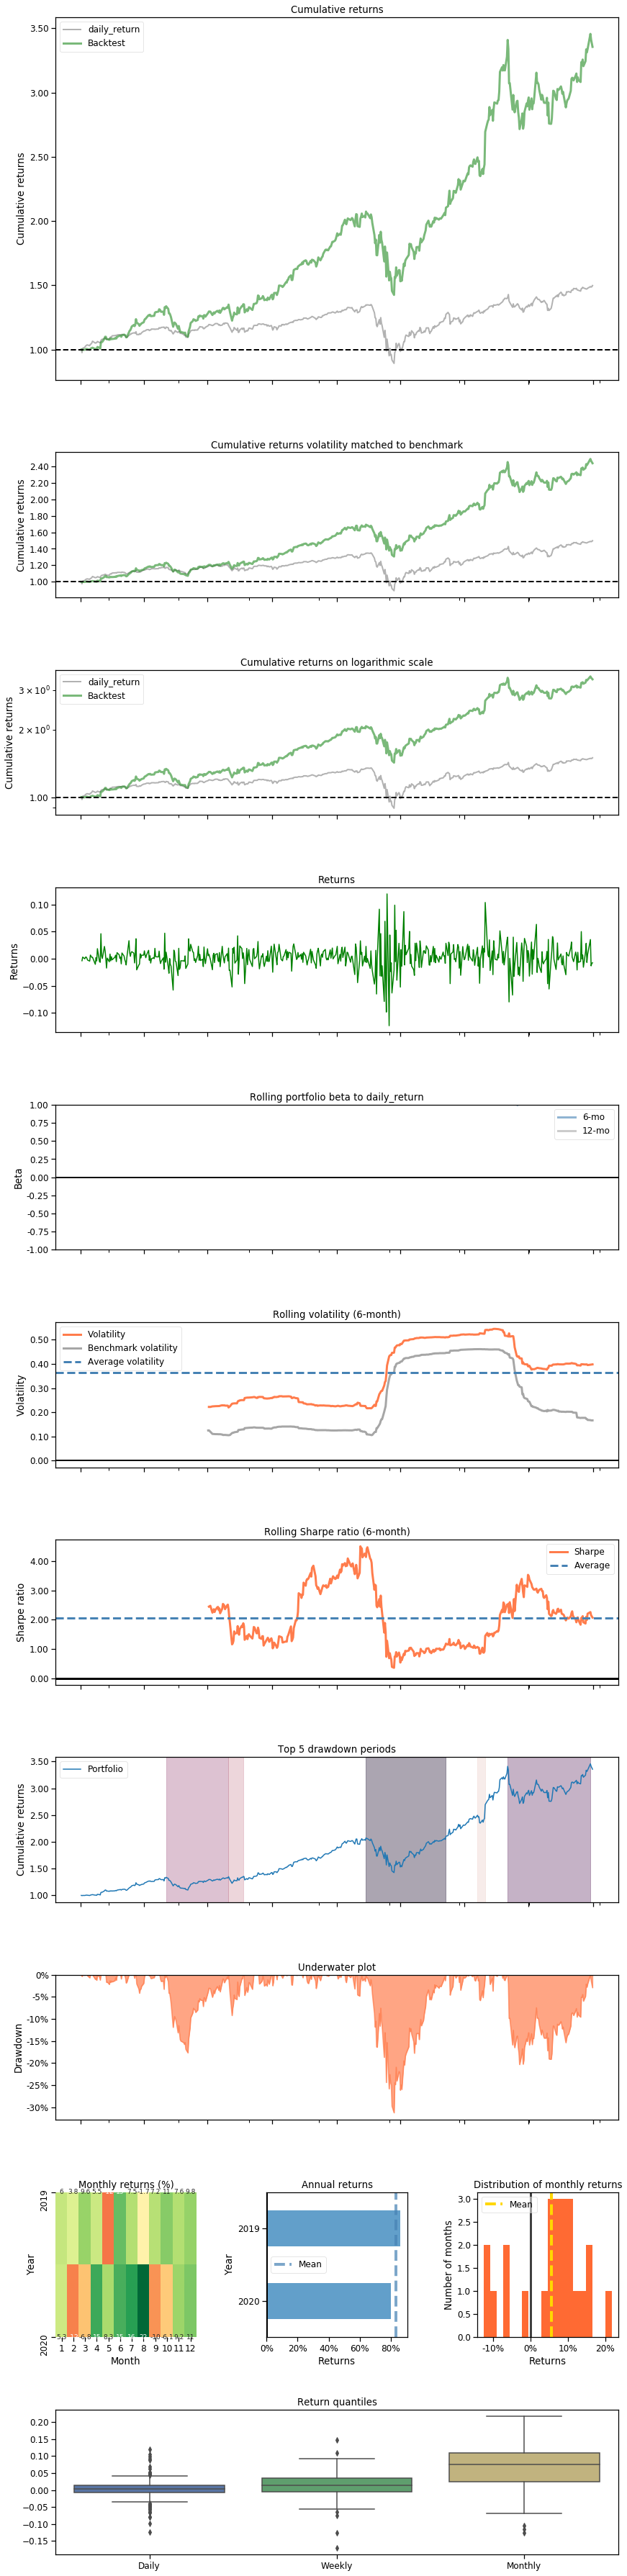

In [33]:
print("==============Compare to S&P 500===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, baseline_ticker = '^GSPC')